In [7]:
!pip install pandas

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
splits = {'train': 'train.jsonl', 'test': 'test.jsonl'}

# Ensure you are loading the correct file paths and remove undefined parts
df_train = pd.read_json("hf://datasets/SetFit/tweet_sentiment_extraction/" + splits["train"], lines=True)
df_test = pd.read_json("hf://datasets/SetFit/tweet_sentiment_extraction/" + splits["test"], lines=True)

# Display the first few rows of the datasets
df_train.head()

,textID,text,label,label_text
0,cb774db0d1,"I`d have responded, if I were going",1,neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,0,negative
2,088c60f138,my boss is bullying me...,0,negative
3,9642c003ef,what interview! leave me alone,0,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",0,negative


In [4]:
from sklearn.utils import resample

majority_class = df_train['label'].value_counts().idxmax()
minority_class = df_train['label'].value_counts().idxmin()

dfs = [df_train[df_train['label'] == i] for i in df_train['label'].unique()]

target_size = min(df_train['label'].value_counts())
balanced_dfs = [resample(d, replace=False, n_samples=target_size, random_state=42) if len(d) > target_size else d for d in dfs]

# Option 2: Oversample minority classes
# target_size = max(df['label'].value_counts())  # Set target size as the size of the largest class
# balanced_dfs = [resample(d, replace=True, n_samples=target_size, random_state=42) if len(d) < target_size else d for d in dfs]

# Combine balanced subsets
balanced_df = pd.concat(balanced_dfs)

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
print(balanced_df['label'].value_counts())


label
0    7781
2    7781
1    7781
Name: count, dtype: int64


In [5]:
import re

# Simple text cleaning function
def simple_cleaning(text):
    if not isinstance(text, str):  # Handle non-string entries
        return ""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

# Apply the function
balanced_df['text'] = balanced_df['text'].apply(simple_cleaning)

print("Text processing complete!")


Text processing complete!


In [6]:
balanced_df.dropna(inplace=True)
balanced_df.drop_duplicates(subset=['text'],inplace=True)
balanced_df.shape

(23206, 4)

In [7]:
balanced_df.isnull().sum()

textID        0
text          0
label         0
label_text    0
dtype: int64

In [8]:
balanced_df.drop(columns=['textID'],inplace = True)

In [9]:
balanced_df.head()

,text,label,label_text
0,kennedy was reinjured at raw on monday hes go...,0,negative
1,sick with a flu like thing,0,negative
2,_shan_west im so excited to see u its been for...,2,positive
3,mmmm it all sounds tasty i had some spiced ru...,2,positive
4,fml my work uniform is on the washing line,0,negative


In [10]:
balanced_df.label.value_counts()

label
0    7758
1    7754
2    7694
Name: count, dtype: int64

In [11]:
balanced_df.drop(balanced_df[balanced_df['label'] == 1].index, inplace=True)

In [12]:
balanced_df.label.value_counts()

label
0    7758
2    7694
Name: count, dtype: int64

In [13]:
balanced_df.to_csv("cleaned_dataset.csv", index=False)

In [14]:
df1 = pd.read_csv("cleaned_dataset.csv")
df1.shape

(15452, 3)

In [15]:
df1.isnull().sum()

text          0
label         0
label_text    0
dtype: int64

In [16]:
df1.dropna(inplace=True)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import joblib

# Separate features and target
X = df1['text']  # Feature column
y = df1['label']  # Target column

# Split into train and test sets
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Vectorize the text data using TF-IDF
vectorizer = CountVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_vectorized = vectorizer.fit_transform(X_train_text).toarray()
X_test_vectorized = vectorizer.transform(X_test_text).toarray()
joblib.dump(vectorizer, "./countvectorizer.pkl")

# Save the processed datasets into a single .npz file
np.savez('processed_dataset.npz',
         X_train=X_train_vectorized,
         X_test=X_test_vectorized,
         y_train=y_train,
         y_test=y_test)

print("Processed data saved successfully as 'processed_dataset.npz'.")


Processed data saved successfully as 'processed_dataset.npz'.


In [18]:
# Load the .npz file
data = np.load('processed_dataset.npz')

# Access the individual arrays
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

# Print the shapes of the original dataset
print("Original Data Shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

# Reduce the dataset size by selecting a subset (e.g., 10%)
# subset_size = int(0.5 * X_train.shape[0])  # 10% of the dataset
# X_train_subsampled = X_train[:subset_size]
# y_train_subsampled = y_train[:subset_size]

# Print the shapes of the reduced dataset
# print("\nReduced Data Shapes:")
# print("X_train_subsampled:", X_train_subsampled.shape)
# print("y_train_subsampled:", y_train_subsampled.shape)

# Now you can use the reduced dataset for training



Original Data Shapes:
X_train: (10816, 10000)
X_test: (4636, 10000)
y_train: (10816,)
y_test: (4636,)


In [19]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train Multinomial Naive Bayes
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = model.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.864106988783434
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      2328
           2       0.88      0.84      0.86      2308

    accuracy                           0.86      4636
   macro avg       0.86      0.86      0.86      4636
weighted avg       0.86      0.86      0.86      4636



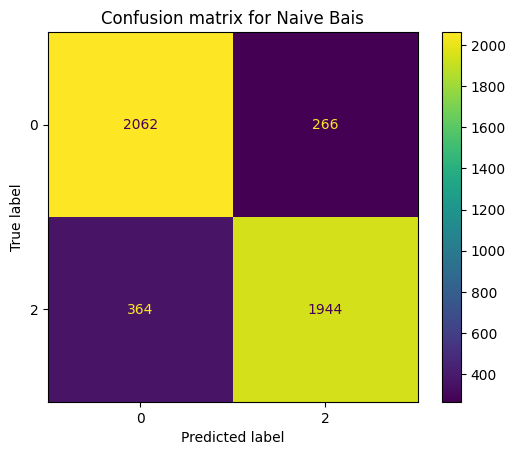

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion matrix for Naive Bais")
plt.show()

HYPER TUNING RF MODEL

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define the hyperparameter space for alpha
param_dist = {
    'alpha': np.logspace(-3, 3, 7)  # Exploring values from 0.001 to 1000
}

# Initialize Multinomial Naive Bayes
model = MultinomialNB()

# Set up RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the randomized search to the data
random_search.fit(X_train_vectorized, y_train)

# Best parameters found by RandomizedSearchCV
print("Best Parameters:", random_search.best_params_)

# Best model with the optimal hyperparameters
best_model = random_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test_vectorized)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'alpha': np.float64(1.0)}
Accuracy: 0.864106988783434
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      2328
           2       0.88      0.84      0.86      2308

    accuracy                           0.86      4636
   macro avg       0.86      0.86      0.86      4636
weighted avg       0.86      0.86      0.86      4636



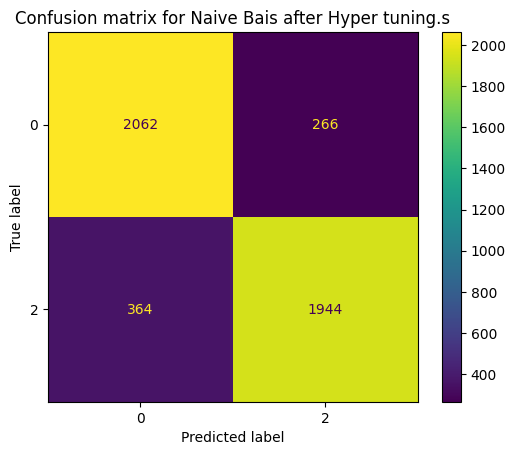

In [22]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion matrix for Naive Bais after Hyper tuning.s")
plt.show()

In [23]:
import joblib

joblib.dump(best_model, "sentiment_analysis.pkl")

['sentiment_analysis.pkl']

In [24]:
# 0 : negative 2: positive
def predict_input_text(input_text):
    # Transform the input text using the same vectorizer that was used during training
    input_vector = vectorizer.transform([input_text])

    # Use the trained model to predict the class label
    prediction = best_model.predict(input_vector)

    return prediction[0]  # Return the predicted label

# Example usage
input_text ="I feel so relaxed and happy after my vacation. It was perfect in every way."
predicted_class = predict_input_text(input_text)

print(f"Predicted Class: {predicted_class}")

Predicted Class: 2
